### Attacking VGG trained on CIFAR10

In this notebook we aim to perform an adversarial attack against a black-box model trained on *Cifar10* 

**Running on COLAB**

If we run the model on *Colab* we need to set the enviroment is this way:

    In[0]: from google.colab import drive
           drive.mount('/content/gdrive')
    
    In[1]: cd /content/gdrive/My Drive/Colab Notebooks/Adversarial/AdvAttack/src

**Import packages**

In [1]:
import src.loss as customLoss
import src.zeroOptim as zeroOptim
import src.dataset as data

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tqdm import tqdm


import torch
from torch import nn, optim
from torchvision import transforms
from src.models import MyVGG

**Retrieve CIFAR10 data**

We retrieve the CIFAR10 data. <br>
We use the *standard* option to retrieve the unnormalized and unchanged data. 

Files already downloaded and verified
Files already downloaded and verified

Batch is a <class 'list'>
The 1st element is a <class 'torch.Tensor'> with shape torch.Size([32, 3, 32, 32])
The 2nd element is a <class 'torch.Tensor'> with shape torch.Size([32])


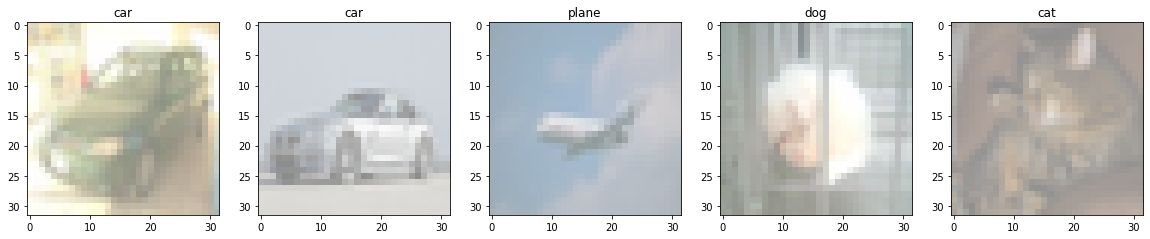

In [2]:
DataLoader = data.CIFAR10(transform='standard')
train, test = DataLoader.get_dataloader(batch_size=32, num_workers=0)
DataLoader.get_info()

In [8]:
device = torch.device('cuda')
net = MyVGG().to(device)
net.load_state_dict(torch.load('models/VGG16_cifar10_state_dict.pth'))

<All keys matched successfully>

In [9]:
for batch in test:
    X, y = batch[0].to(device), batch[1].to(device)

In [10]:
out = net(X)
y_pred = torch.argmax(out, axis=1)
match = y_pred - y.to(device)
TP = match[match == 0].shape[0]
print('Accuracy is {:.2f}'.format(TP/X.shape[0]))

Accuracy is 0.88


### MAIN
**5. ADVERSARIAL ATTACK**

Here we try to start with a random rightfully classified image from the validation set and we try to use *Zero-order Stochastic Conditional Gradient* to modify the image in order to make the network be mistaken.

We can set an epsilon as an upper bound for the inifinity norm of our input.

**Args:**

        Name            Type                Description
        
        x:              (torch.tensor)      The variable of our optimization problem. Should be a 3D tensor (img)
        v:              (float)             The gaussian smoothing
        mk:             (list)              Number of normal vector to generate at every step
        ak              (list)              Pseudo learning rate/momentum  every step
        epsilon:        (float)             The upper bound of the infinity norm
        C:              (tuple)             The boundaries of the pixel. Default is (0, 1)
        max_steps:      (int)               The maximum number of steps. Default is 100
        stop_criterion  (float)             The minimum loss function. Default is 1e-3
        verbose:        (int)               Display information or not. Default is 0
        additional_out  (bool)              Return also all the x. Default is False
        tqdm_disable    (bool)              Disable the tqdm bar. Default is False

**Suggested values** <br>
*Zeroth-order Nonconvex Stochastic Optimization: Handling Constraints, High-Dimensionality and Saddle-Points* (rishnakumar Balasubramanian†1 and Saeed Ghadimi‡2):

$v = \sqrt{\frac{2B_{L_{\sigma}}}{N(d+3)^3}}$, 
$\alpha_{k} =\frac{1}{\sqrt{N}}$,
$m_{k} = 2B_{L_{\sigma}}(d + 5)N$,
$\forall k \geq 1$

where:<br>
- *N* is the number of steps <br>
- *d* is the dimension of *x* <br>
- $B_{L_{\sigma}} ≥ max\bigg\{\sqrt{\frac{B^2 + \sigma^2}{L}}, 1\bigg\}$

**E.G:** <br>
If we set $N = 100$, $B_{L_{\sigma}} = 1$ and we have a image 32 * 32 * 3($d = 3072$) we have: <br>

- $v = 10e-6$
- $\alpha_{k} = 0.1$
- $m_{k} = 30770$

**N.B** <br>
In reality it seems that $\alpha_{k}$ could be set much higher (e.g. 0.5)  and $m_{k}$ could be set a bit lower (e.g. 600)  

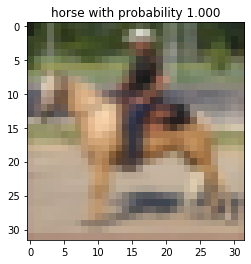

In [6]:
net.eval()
img = X[0].cpu().numpy()
out = nn.Softmax(dim=1)(net(X[0].reshape(1, *list(img.shape))))
plt.imshow(np.transpose(img, (1, 2, 0)))
original_label = torch.argmax(out).item()
plt.title('{} with probability {:.3f}'.format(DataLoader.classes[original_label], float(out[0, original_label])))
plt.show()

**5.1 General attack**

Here we try to manipulate the input such that it will be misclassified in favor of a whatever class. Usually its easier and we deal with the problem by minimizing the probability of the true class  

*E.g.* <br> 
We want to try to minimize the probability of classification of neuron *zero*

In [8]:
# 1. Define Params
EPOCH = 300

params = {'x': X[0], 'v': 0.001, 'mk': [32**2]*EPOCH, 
          'ak': [1/(EPOCH**0.5)]*EPOCH,
          'epsilon': 0.25, 'max_steps': EPOCH, 'verbose': 0}

  0%|                                                                                          | 0/300 [00:00<?, ?it/s]


Process complete after 1 steps


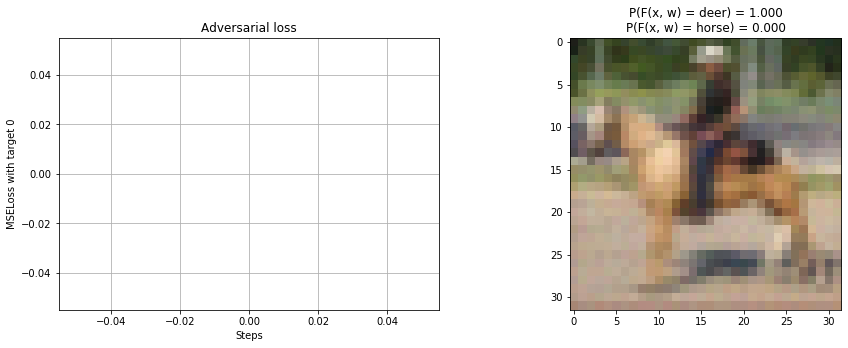

In [9]:
# 2. Define loss and call the optimizer
adv_loss = customLoss.ZooLoss(neuron=original_label, maximise=0, is_softmax=False, dim=1)
adv_optimizer = zeroOptim.ClassicZSCG(net, adv_loss, 'cuda')

# 3. Run the optimizer
EPOCH = 400
x, loss, outs = adv_optimizer.run(**params)
print('Process complete after {} steps'.format(len(loss)))

# 4. Compute manually last output
out = nn.Softmax(dim=1)(net(x.reshape(1, 3, 32, 32)))
label = torch.argmax(out).item()
img = x.detach().cpu().numpy()

# 5. Display results
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(loss)
ax[0].set_title('Adversarial loss')
ax[0].set_ylabel('MSELoss with target 0')
ax[0].set_xlabel('Steps')
ax[0].grid()
ax[1].imshow(np.transpose(img, (1, 2, 0)))
ax[1].set_title('P(F(x, w) = {}) = {:.3f}\nP(F(x, w) = {}) = {:.3f}'.format(DataLoader.classes[label], 
                                                                            float(out[0, label]), 
                                                                             DataLoader.classes[original_label], 
                                                                            float(out[0, original_label])))
plt.show()

**5.2 Specific attack**

Here we try to manipulate the input such that it will be misclassified in favor of a *specific* class.

*E.g.* <br> 
We want to try to maximise the probability of classification of neuron *three*

**N.B** <br>
In this case *MSELoss* seems not able to do the trick, the loss remains constant at *0.5* for all the steps. On the other hand here *ZooLoss* manages to perform the attack immediatly.

  1%|▌                                                                                 | 2/300 [00:02<06:19,  1.27s/it]


Process complete after 3 steps


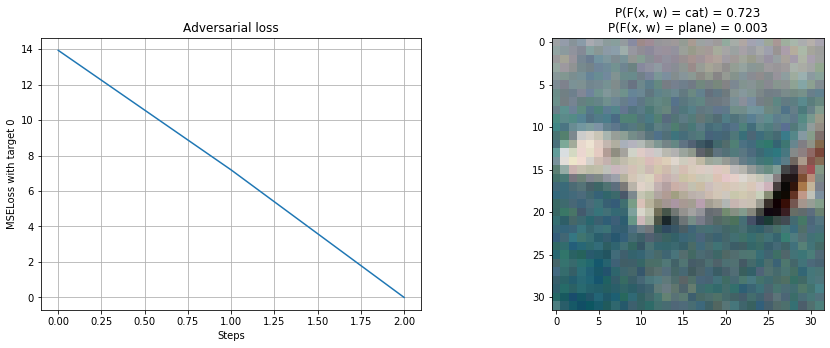

In [15]:
# 2. Define loss and call the optimizer
adv_loss = customLoss.ZooLoss(neuron=original_label+1, maximise=1, is_softmax=False, dim=1)
adv_optimizer = zeroOptim.ClassicZSCG(net, adv_loss, 'cuda')

# 3. Run the optimizer
EPOCH = 400
x, loss, outs = adv_optimizer.run(**params)
print('Process complete after {} steps'.format(len(loss)))

# 4. Compute manually last output
out = nn.Softmax(dim=1)(net(x.reshape(1, 3, 32, 32)))
label = torch.argmax(out).item()
img = x.detach().cpu().numpy()

# 5. Display results
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(loss)
ax[0].set_title('Adversarial loss')
ax[0].set_ylabel('MSELoss with target 0')
ax[0].set_xlabel('Steps')
ax[0].grid()
ax[1].imshow(np.transpose(img, (1, 2, 0)))
ax[1].set_title('P(F(x, w) = {}) = {:.3f}\nP(F(x, w) = {}) = {:.3f}'.format(DataLoader.classes[label], 
                                                                            float(out[0, label]), 
                                                                             DataLoader.classes[original_label], 
                                                                            float(out[0, original_label])))
plt.show()